In [27]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from scipy.interpolate import interp1d

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

A huge amount of work has gone into finding TRAPPIST-1's characteristics, we're not going to improve on that for a quick paper. Trick is then to find the best ones. https://ui.adsabs.harvard.edu/abs/2017ApJ...845..110B/abstract does a lot of work on this. Parameters we need for a Phoenix model are Teff, Logg, Fe/H and $\alpha$/M. 

Teff = 2560 ± 50 K  
Radius = 0.117 ± 0.004 ${R}_{\odot }$ or  0.121 ± 0.003 ${R}_{\odot }$ - 2nd one is probably better.  
Mass = 0.080 ± 0.007 ${M}_{\odot }$  
Fe/H = +0.04 ± 0.08 dex  

No value for $\alpha$, I'll assume Solar value.

In [2]:
#logg g = Gm/r**2
G = const.G
R = 0.121*u.Rsun
M = 0.08*u.Msun
g = (G*M.to(u.kg)/R.to(u.m)**2)
print(g)
g = g.to(u.cm/u.s**2)
print(g)
logg = np.log10(g.value)
print(logg)


1498.258925796725 m / s2
149825.8925796725 cm / s2
5.175586873662176


Ok, so closest Phoenix values are Teff = 2600, logg = 5.0, Fe/H = 0, $\alpha$/M = 0. Maybe interpolate a better temperature spectrum?

In [3]:
mw = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits',0)
mf2500 = fits.getdata('lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
mf2600 = fits.getdata('lte02600-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

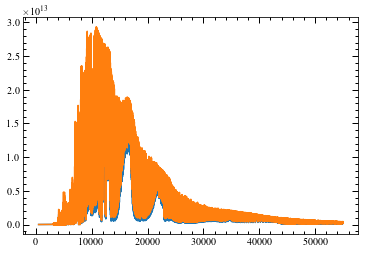

In [4]:
plt.step(mw, mf2500)
plt.step(mw, mf2600)

In [5]:
from scipy import interpolate

In [6]:
mf2560 = interpolate.interp1d([2500, 2600], [mf2500, mf2600], axis=0)(2560)

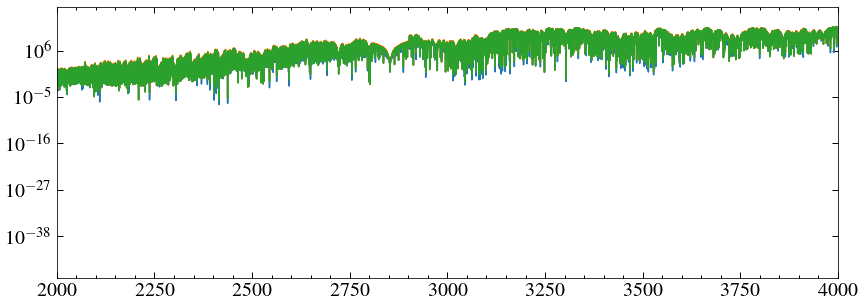

In [57]:
plt.step(mw, mf2500)
plt.step(mw, mf2600)
plt.step(mw, mf2560)
plt.xlim(2000, 4000)
plt.yscale('log')

Yay!

In [8]:
phottab = 'trappist-1_vizer_photometry.vot'
from astropy.io.votable import parse
votable = parse(phottab)
table = votable.get_first_table()
data = table.array

In [9]:
c = const.c.value


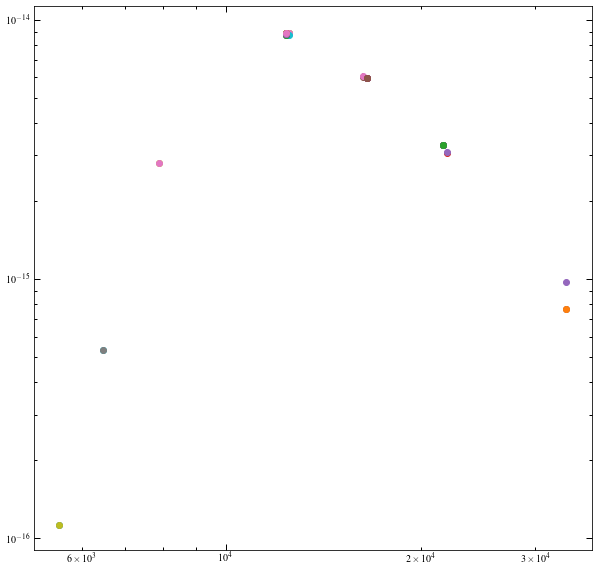

In [10]:
#mask = ~data['sed_eflux'].mask
#masked_data = data[mask].data
masked_data = data.data
w = []
f = []
e = []
filters = []
for i in range(len(masked_data['sed_freq'])):
    w.append(10.*c/masked_data['sed_freq'][i])
    f.append(2.99792458E-05*masked_data['sed_flux'][i]/(w[i]**2))
    e.append((masked_data['sed_eflux'][i]*f[i])/masked_data['sed_flux'][i])
    filters.append(masked_data['sed_filter'][i])
#print(w,f,e)

plt.figure('sed', figsize=(10,10))
for i in range(len(w)):
    if e[i] !=0.0:
        plt.errorbar(w[i], f[i], yerr=e[i], marker='o', ls='none')
    else:
        plt.errorbar(w[i], f[i], yerr=f[i]*0.1, marker='o', ls='none', uplims=True)
plt.yscale('log')
plt.xscale('log')

Blergh, no errorbars on a lot of them. Try without errors? I'm not using them for the scaling yet. Ok, just need to switch commented lines at the top to mask the data.

In [11]:
bw = Table.read('../../../vizer_bandwidths.csv')

In [12]:
def residuals(scale, f, mf):
    return f - mf/scale

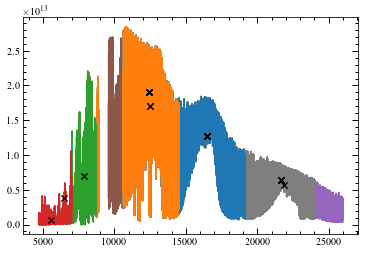

[4.71774681e-28]


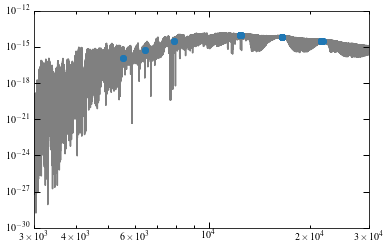

NameError: name 'e_scale' is not defined

In [13]:
scales = []
w_abs = []
flt = []
f_abs = []
e_abs = []
m_phot = []
mf = mf2560
for i in range(len(w)):
    if w[i] < mw[-1] and str(filters[i]) in bw['bandname']:
        w_abs.append(w[i])
        flt.append(filters[i])
        f_abs.append(f[i])
        e_abs.append(e[i])
        bp = bw[bw['bandname']==str(filters[i])]
        mask = (mw > bp['l_start']) & (mw < bp['l_end'])
        bmw, bmf = mw[mask], mf[mask]
        intflux = np.trapz(bmf, bmw)
        plt.plot(bmw, bmf, zorder=-100)
        plt.plot(w[i], intflux/(bp['l_end']-bp['l_start']), 'kx')
        mp = intflux/(bp['l_end']-bp['l_start'])
        m_phot.append(mp[0])
        scale = f[i]/mp[0]
        scales.append(scale)
plt.show()
        
    
        

w_abs = np.array(w_abs) 
arr1inds = w_abs.argsort()
w_abs = w_abs[arr1inds]
scales = np.array(scales)[arr1inds]
f_abs = np.array(f_abs)[arr1inds]
e_abs = np.array(e_abs)[arr1inds]
m_phot = np.array(m_phot)[arr1inds]
             
scale, flag = leastsq(residuals, 1., args=(f_abs, m_phot))
print(1/scale)
    
plt.figure('sed')
plt.errorbar(w_abs, f_abs, yerr=e_abs, marker='o', ls='none', label = filters[i])
plt.yscale('log')
plt.xscale('log')
plt.plot(mw, mf/scale, zorder=-100, c='0.5')
plt.xlim(3000, 30000)
plt.ylim(1e-30, 1e-12)
plt.show()


plt.errorbar(w_abs, scales*scale, yerr = e_scale/mean_scale, marker='o', ls ='none')
plt.xscale('log')
plt.axhline(1.0, c='k', ls ='--')
plt.show()

Again the blue is bad, but they were the ones without error bars. Also less data at that end.

In [ ]:
data = Table([mw*u.AA, (mf/scale)], names = ['WAVELENGTH', 'FLUX'] )
ascii.write(data, 'scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv', delimiter=',', format='ecsv')

In [ ]:
dt = Table.read('scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
plt.plot(dt['WAVELENGTH'], dt['FLUX'])
plt.yscale('log')
plt.xscale('log')
plt.errorbar(w_abs, f_abs, yerr=e_abs, marker='o', ls='none')
plt.xlim(3000, 30000)
plt.ylim(1e-30, 1e-12)

Where does the photmetry come from?

In [ ]:
data.dtype.names

In [ ]:
data['_tabname']

In [ ]:
data = Table([mw*u.AA, mf], names = ['WAVELENGTH', 'FLUX'] )
ascii.write(data, 'unscaled_02560-5.00-0.0_phoenix_trappist-1.ecsv', delimiter=',', format='ecsv')

In [ ]:
#dt = Table.read('scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
#plt.plot(dt['WAVELENGTH'], dt['FLUX'])
#2.795159077348712e-28
plt.step(mw, mf2560*2.8e-28)
plt.yscale('log')
plt.xscale('log')
plt.errorbar(w_abs, f_abs, yerr=e_abs, marker='o', ls='none')
plt.xlim(3000, 30000)
plt.ylim(1e-30, 1e-12)

20190731 messed up the scaling to the spectrum somewhere:

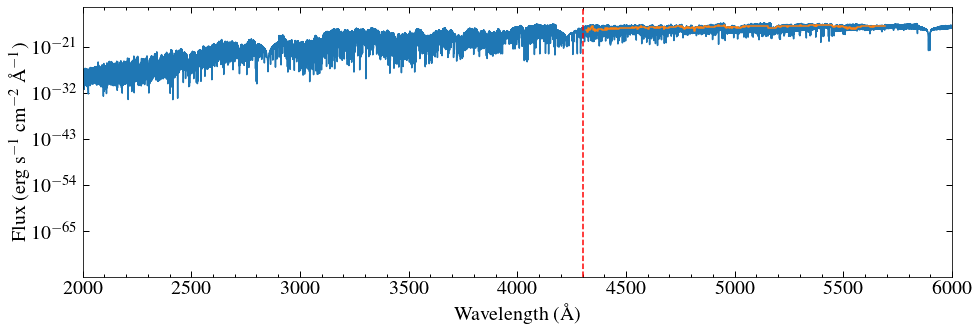

1.5660874758874485e-28

In [58]:
def residuals(scale, f, mf):
    return f - mf/scale

def phoenix_norm(star, w_phx, f_phx, ccd_path, plot=False, cut=2000): 
    """
    find the normalisation factor between the phoenix model and the stis ccd (ccd_path)
    """
    data = fits.getdata(ccd_path)[0]
    w, f, dq = data['WAVELENGTH'], data['FLUX'], data['DQ']
    #mask =  (dq ==0)
    mask = (w > cut) & (f > 0) & (dq ==0)
    w1, f1 = w[mask], f[mask]
    norm_mask = (w_phx >= w1[0]) & (w_phx <= w1[-1])
    phx_flux = interp1d(w_phx[norm_mask], f_phx[norm_mask], fill_value='extrapolate')(w1)
    #phx_int_flux = np.trapz(f_phx[norm_mask], w_phx[norm_mask])
    #ccd_int_flux = np.trapz(f1, w1)
    #normfac = ccd_int_flux / phx_int_flux
    scale, flag = leastsq(residuals, 1., args=(f1, phx_flux))
    normfac = 1/scale[0]

    if plot:
        plt.figure(star+'_scaled')
        plt.plot(w_phx, f_phx*normfac)
        #plt.step(w,f, where='mid')
        plt.step(w1, f1, where='mid')
        plt.xlabel('Wavelength (\AA)', size=20)
        plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
        plt.xlim(2000, 6000)
        plt.yscale('log')
        plt.axvline(cut, c='r', ls='--')
        plt.tight_layout()
        plt.show()
    return normfac

phoenix_norm(star, w_phx, f_phx, ccd_path, plot=True, cut=4300)

In [41]:
#t1_mod = Table.read('unscaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
#w_phx, f_phx = t1_mod['WAVELENGTH'], t1_mod['FLUX']
#ccd_path = '../STIS/odlm41010_sx1.fits'
#star='t1'

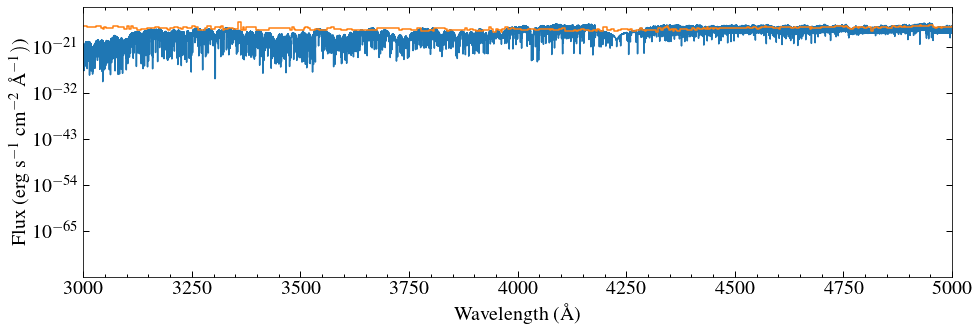

1.4865232886101935e-28

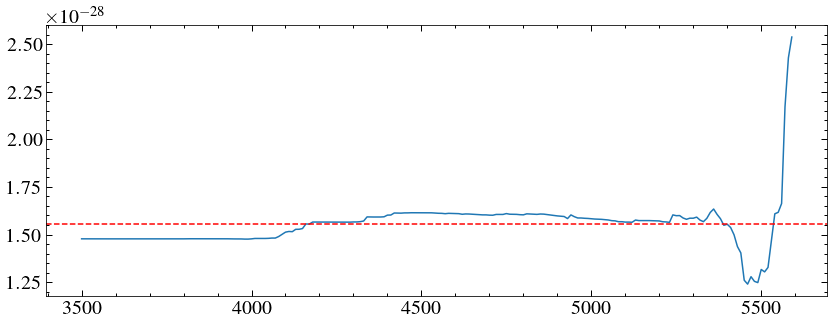

In [61]:
factors = []
#cuts = np.arange(4200, 5400, 10)
cuts = np.arange(3500, 5600, 10)

for c in cuts:
    n = phoenix_norm(star, w_phx, f_phx, ccd_path, plot=False, cut=c)
    factors.append(n)
plt.plot(cuts, factors)
plt.axhline(np.mean(factors), c='r', ls='--')

In [53]:
np.mean(factors)

1.5862171400202698e-28